# Minimum tensor distance from a transverse isotropic and an isotropic one


In this notebook we explore the minimum distance between stiffness/compliance of different symmetry clases; namely, transverse isotropic and isotropic. The former is defined by 5 elstic moduli, while the latter just 2. Stating this in an intuitive way: for a given transverse isotropic material we want to find an _isotropic_ equivalent one. We want to **isotropize** the material XD.

Tha main idea is to find the minimum of

$$\min d(C_\text{iso}, C_\text{trans}) \enspace ,$$

being $d(A, B)$ a distance function between $A$ and $B$. The distance functions used are:
1. Frobenius norm: $d_F(A,B) = \Vert A - B\Vert$
2. Log-Euclidean norm: $d_L(A,B) = \Vert \log{A} - \log{B}\Vert$
3. Riemman norm: $d_R(A,B) = \Vert \log{A^{-1/2}BA^{1/2}}\Vert$

where $\Vert M\Vert = [\text{tr}{M^T M}]^{1/2}$. The last two are of interest since they are invariant under inversion, i.e., $d_{F/L}(A^{-1}, B^{-1}) = d_{F/L}(A, B)$, a property that is of interest for the physical nature of the tensors.

In [1]:
import numpy as np
import scipy
from scipy.linalg import sqrtm, fractional_matrix_power
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from numba import jit

In [2]:
%matplotlib notebook

In [3]:
"""
Distance functions for 4th order tensors, equivalently it can be
used for (6,6) positive definite symmetric matrices.
"""


def voigt_to_mandel(A):
    r"""Convert from Voigt to Mandel notation
    
    In Voigt notation the tensor is represented as
    
    .. math::
        C = \begin{pmatrix}
        C_{11} & C_{12} & C_{13} & C_{14} & C_{15} & C_{16}\\
        C_{12} & C_{22} & C_{23} & C_{24} & C_{25} & C_{26}\\
        C_{13} & C_{23} & C_{33} & C_{34} & C_{35} & C_{36}\\
        C_{14} & C_{24} & C_{34} & C_{44} & C_{45} & C_{46}\\
        C_{15} & C_{25} & C_{35} & C_{45} & C_{55} & C_{56}\\
        C_{16} & C_{26} & C_{36} & C_{46} & C_{56} & C_{66}
        \end{pmatrix}
        
    and, ind Mandel notation it is represented as
    
    .. math::
        \hat{C} = \begin{pmatrix}
        C_{11} & C_{12} & C_{13} & \sqrt{2}C_{14} & \sqrt{2}C_{15} & \sqrt{2}C_{16}\\
        C_{12} & C_{22} & C_{23} & \sqrt{2}C_{24} & \sqrt{2}C_{25} & \sqrt{2}C_{26}\\
        C_{13} & C_{23} & C_{33} & C_{34} & C_{35} & C_{36}\\
        \sqrt{2}C_{14} & \sqrt{2}C_{24} & \sqrt{2}C_{34} & 2C_{44} & 2C_{45} & 2C_{46}\\
        \sqrt{2}C_{15} & \sqrt{2}C_{25} & \sqrt{2}C_{35} & 2C_{45} & 2C_{55} & 2C_{56}\\
        \sqrt{2}C_{16} & \sqrt{2}C_{26} & \sqrt{2}C_{36} & 2C_{46} & 2C_{56} & 2C_{66}
        \end{pmatrix}
    
    Parameters
    ----------
    A : (6,6) array_like
        Positive-semidefinite matrix representing stiffness/compliance
        tensors.
    
    References
    ----------
    .. [1] Voigt notation. (2015, January 9). In Wikipedia, The Free
        Encyclopedia. Retrieved May 12, 2015, from 
        http://en.wikipedia.org/wiki/Voigt_notation
        
    .. [2] M. Mehrabadi, S.C Cowin. "Eigentensor of linear anisotropic
        elastic materials". Q.J. Mech. Appl. math, 43 (1990), 15-41.
        
    .. [3] P. Helnwein (2001). Some Remarks on the Compressed Matrix
        Representation of Symmetric Second-Order and Fourth-Order
        Tensors. Computer Methods in Applied Mechanics and Engineering,
        190(22-23):2753-2770
 
    Examples
    --------
    Let us test with a matrix of ones.
    
    >>> A = np.ones((6,6))
    >>> print np.round(voigt_to_mandel(A), 4)
    [[ 1.      1.      1.      1.4142  1.4142  1.4142]
     [ 1.      1.      1.      1.4142  1.4142  1.4142]
     [ 1.      1.      1.      1.4142  1.4142  1.4142]
     [ 1.4142  1.4142  1.4142  2.      2.      2.    ]
     [ 1.4142  1.4142  1.4142  2.      2.      2.    ]
     [ 1.4142  1.4142  1.4142  2.      2.      2.    ]]
    
    
    """
    B = A.copy()
    B[0:3,3:6] = np.sqrt(2)*B[0:3,3:6]
    B[3:6,0:3] = np.sqrt(2)*B[3:6,0:3]
    B[3:6,3:6] = 2*B[3:6,3:6]
    
    return B

def mat_norm(A):
    r"""Compute the norm of a matrix
    
    The norm is given by
    .. math::
        \Vert A\Vert = [\text{tr}{A^T A}]^{1/2}
   
    Parameters
    ----------
    A : (n,n) ndarray
        Real matrix.

    Returns
    -------
    norm : float, nonnegative
        Norm of the matrix.
        
    Examples
    --------
    The following matrix has as Frobenius norm $\sqrt{10}$.
    >>> A = np.array([[2,-1],
    ...               [-1,2]])
    >>> print np.round(mat_norm(A), 6)
    3.162278
    
    >>> A = np.array([
    ... [-3, 5, 7],
    ... [2, 6, 4],
    ... [0, 2, 8]])
    >>> print np.round(mat_norm(A), 6)
    14.387495
    
    """
    norm = np.sqrt(np.trace(np.dot(A.T, A)))
    return norm


def elastic_tensor_dist(A, B, dist="riemman"):
    r"""Compute the distant function for the tensor `A` and `B`

    The distance functions are
    
    .. math::
        \begin{align}
        &d_F(A,B) = \Vert A - B\Vert\\
        &d_L(A,B) = \Vert \log{A} - \log{B}\Vert\\
        &d_R(A,B) = \Vert \log{A^{-1/2}BA^{1/2}}\Vert
        \end{align}

    where :math:`\Vert M\Vert = [\text{tr}{M^T M}]^{1/2}`. 

    References
    ----------
    .. [1] Norris, Andrew. "The isotropic material closest to a given
        anisotropic material." Journal of Mechanics of Materials and
        Structures 1.2 (2006): 223-238.

    .. [2] Moakher, Maher, and Andrew N. Norris. "The closest elastic
        tensor of arbitrary symmetry to an elasticity tensor of lower
        symmetry." Journal of Elasticity 85.3 (2006): 215-263.
        
        
    Examples
    --------
    >>> import homogenization as homog
    >>> C_Ag = homog.cubic_stiff(43.75, 46.1, 0.43)
    >>> C_W = homog.cubic_stiff(407.43, 160.8, 0.28)
    >>> print np.round(elastic_tensor_dist(C_Ag, C_W), 6)
    14.597203
    
    >>> print np.round(elastic_tensor_dist(C_Ag, C_W, 'log'), 6)
    4.102959
    
    >>> print np.round(elastic_tensor_dist(C_Ag, C_W, 'frob'), 6)
    836.529651

    """
    A = voigt_to_mandel(A)
    B = voigt_to_mandel(B)
    
    if dist=="frob":
        C = A - B

    if dist=="riemman":
        C = np.dot(B, sqrtm(A))
        C = np.dot(fractional_matrix_power(A, -0.5), C)
        C = scipy.linalg.logm(C)

    if dist=="log":
        C = scipy.linalg.logm(A) -  scipy.linalg.logm(B) 
    
    return mat_norm(C)


def trans2iso(props, tensor_type="compliance"):
    """Return the closest isotropic tensor to an transverse isotropic one

    Parameters
    ----------
    props : list, [Ep, Et, nu_p, nu_tp, Gt]
        Material properties:
        
        - Ep : float, >0
            Young modulus in perpendicular to the axis of symmetry, i.e.,
            in the plane of isotropy.
        - Et : float, >0
            Young modulus in the direction of the axis of symmetry.
        - nu_p : float, (-1, 1)
            Poisson ratio in the plane of isotropy.
        - nu_tp : float, (-1, 1)
            Poisson ratio characterizing transverse cotnraction in the plane
            of isotropy when tension is applied normal to the plane.
        - Gt : float, >0
            Shear modulus for the plane perpendicular to the symmetry plane.
    tensor_type : string (optional)
        String showing the type of tensor used for the minimization:
        `stiffness` or `compliance`.
        
    Returns
    -------
    E : float, >0
        Young modulus for the istropic solid.
    nu : float, (-0.5, 1)
        Poisson ratio for the istropic solid.
        
    Examples
    --------
    Let us consider a transverse isotropic solid given by
    `Ep = 9.7e9`, ``Et = 153.75e9``, ``nu_p = 0.672, ``nu_tp = 0.344``,
    ``Gt = 5.79e9``.
    
    >>> Ep = 9.7e9
    >>> Et = 153.75e9
    >>> nu_p = 0.672
    >>> nu_tp = 0.344
    >>> Gt = 5.79e9
    >>> props = [Ep, Et, nu_p, nu_tp, Gt]

    Minimizing the Frobenius distance for the compliance tensor we should
    ``E = 1.225269e10`` and ``nu = 0.3682``.

    >>> E, nu = trans2iso(props)
    >>> np.abs(E - 1.225269e10)/1.225269e10 < 0.01
    True
    >>> np.abs(nu - 0.3682)/0.3682 < 0.01
    True

    In the case of stiffnes tensor, the values are ``E = 5.136497e10`` and
    ``nu = 0.2112``.
    
    >>> E, nu = trans2iso(props, tensor_type="stiffness")
    >>> np.abs(E - 5.136497e10)/5.136497e10 < 0.01
    True
    >>> np.abs(nu - 0.2112)/0.2112 < 0.01
    True
        
    """
    Ep, Et, nu_p, nu_tp, Gt = props
    if tensor_type=="compliance":
        E = -21*Et*Ep*Gt/(((8*nu_tp - 3)*Ep - 10*Et)*Gt - 4*Et*Ep)
        nu = -(((10*nu_tp - 2)*Ep + (7*nu_p - 2)*Et)*Gt + 2*Et*Ep)/(
        ((8*nu_tp - 3)*Ep - 10*Et)*Gt - 4*Et*Ep)
    if tensor_type=="stiffness":
        E = -((((96*nu_tp**3 + 48*nu_tp**2)*nu_p + 96*nu_tp**3 + 48*nu_tp**2)
        *Et*Ep**2 + ((-24*nu_tp**2 + 48*nu_tp + 24)*nu_p**2 + 24*nu_tp**2-
        48*nu_tp-24)*Et**2*Ep + (-12*nu_p**3 + 12*nu_p**2 + 12*nu_p-12)*Et**3)
        *Gt + (120*nu_tp**3 + 60*nu_tp**2)*Et*Ep**3 + ((34*nu_tp**2 + 76*nu_tp
        + 22)*nu_p + 94*nu_tp**2-44*nu_tp-38)*Et**2*Ep**2 +
        ((16*nu_tp + 5)*nu_p**2 + 30*nu_p-16*nu_tp-35)*Et**3*Ep +
        (-8*nu_p**3 + 8*nu_p**2 + 8*nu_p-8)*Et**4)/(((48*nu_tp**4*nu_p
        + 48*nu_tp**4)*Ep**2 + (48*nu_tp**2*nu_p**2-48*nu_tp**2)*Et*Ep
        + (12*nu_p**3-12*nu_p**2-12*nu_p + 12)*Et**2)*Gt + 60*nu_tp**4*Ep**3 +
        ((-144*nu_tp**3-36*nu_tp**2)*nu_p-144*nu_tp**3-156*nu_tp**2)*Et*Ep**2
        + ((60*nu_tp**2-72*nu_tp-33)*nu_p**2-30*nu_p-60*nu_tp**2 + 72*nu_tp
        + 63)*Et**2*Ep + (30*nu_p**3-30*nu_p**2-30*nu_p + 30)*Et**3)

        nu = -(((8*nu_tp**2*nu_p + 8*nu_tp**2)*Ep + (4*nu_p**2-4)*Et)*Gt
        + 10*nu_tp**2*Ep**2 + ((20*nu_tp + 11)*nu_p + 20*nu_tp + 1)*Et*Ep
        + (1-nu_p**2)*Et**2)/(((8*nu_tp**2*nu_p + 8*nu_tp**2)*Ep
        + (4*nu_p**2-4)*Et)*Gt + 10*nu_tp**2*Ep**2
        + ((-24*nu_tp-11)*nu_p-24*nu_tp-21)*Et*Ep + (10*nu_p**2-10)*Et**2)

    return E, nu

In [4]:
def iso_stiff(E, nu):
    r"""Form the stiffness tensor in Voigt notation.

    Parameters
    ----------
    E : float
        Young modulus.
    nu : float
        Poisson's ratio.

    Returns
    -------
    stiff : (6,6) ndarray
        Stiffness tensor in Voigt notation.

    Examples
    --------
    Let us consider `E=200` GPa and `nu=0.285`, like in steel, the
    units are GPa to have small numbers.

    >>> from homogenization import iso_stiff
    >>> E = 200
    >>> nu = 0.285
    >>> C = iso_stiff(E, nu)
    >>> print np.round(C,4)
    [[ 258.8001  103.1581  103.1581    0.        0.        0.    ]
     [ 103.1581  258.8001  103.1581    0.        0.        0.    ]
     [ 103.1581  103.1581  258.8001    0.        0.        0.    ]
     [   0.        0.        0.       77.821     0.        0.    ]
     [   0.        0.        0.        0.       77.821     0.    ]
     [   0.        0.        0.        0.        0.       77.821 ]]

    See Also
    --------
    iso_compl

    """

    mu = E / (2.0 * (1.0 + nu))
    lam = E * nu / (1.0 + nu) / (1.0 - 2.0 * nu)

    stiff = np.zeros((6, 6))

    stiff[0, 0] = 2.0 * mu + lam
    stiff[1, 1] = 2.0 * mu + lam
    stiff[2, 2] = 2.0 * mu + lam
    stiff[0, 1] = lam
    stiff[0, 2] = lam
    stiff[1, 0] = lam
    stiff[1, 2] = lam
    stiff[2, 0] = lam
    stiff[2, 1] = lam
    stiff[3, 3] = mu
    stiff[4, 4] = mu
    stiff[5, 5] = mu

    return stiff

In [5]:
def transiso_stiff(Ep, Et, nu_p, nu_tp, Gt):
    """Form the stiffness tensor for transverse isotropic cases.

    Parameters
    ----------
    Ep : float
        Young modulus in the plane of isotropy.
    Et : float
        Young modulus perpendicular to the plane of isotropy.
    nu_p : float
        Poisson's ratio in the plane of isotropy.
    nu_tp : float
        Poisson's ration perpendicular to the plane of isotropy.
    G_t : float
        Shear modulus for the plane perpendicular to the symmetry
        plane.

    Returns
    -------
    stiff : (6,6) ndarray
        Compliance tensor in Voigt notation.


    The axis of symmetry in this case is x3 (z).

    Examples
    --------
    Let us consider a homogeneous material first `E=70` GPa and
    `nu=0.33`, like in aluminum, the  units are GPa to have small
    numbers.

    >>> from homogenization import transiso_stiff
    >>> Ep = 70
    >>> Et = 70
    >>> nu_p = 0.33
    >>> nu_tp = 0.33
    >>> Gt =   Ep/(2*(1 + nu_p))
    >>> C = transiso_stiff(Ep, Et, nu_p, nu_tp, Gt)
    >>> print np.round(C,4)
    [[ 103.7152   51.0836   51.0836    0.        0.        0.    ]
     [  51.0836  103.7152   51.0836    0.        0.        0.    ]
     [  51.0836   51.0836  103.7152    0.        0.        0.    ]
     [   0.        0.        0.       26.3158    0.        0.    ]
     [   0.        0.        0.        0.       26.3158    0.    ]
     [   0.        0.        0.        0.        0.       26.3158]]

    Now, let us consider apatite that has as parameters
    `Ep = 133.50` GPa, `Et = 91.63` GPa, `nu_p = -0.133`,
    `nu_tp = 0.366` and `Gt = 66.3` GPa.

    >>> from homogenization import transiso_stiff
    >>> Ep = 133.498
    >>> Et = 91.6269
    >>> nu_p = -0.1326
    >>> nu_tp = 0.3665
    >>> Gt =   66.3
    >>> C = transiso_stiff(Ep, Et, nu_p, nu_tp, Gt)
    >>> print np.round(C,4)
    [[ 167.0093   13.1033   66.0113    0.        0.        0.    ]
     [  13.1033  167.0093   66.0113    0.        0.        0.    ]
     [  66.0113   66.0113  140.0132    0.        0.        0.    ]
     [   0.        0.        0.       66.3       0.        0.    ]
     [   0.        0.        0.        0.       66.3       0.    ]
     [   0.        0.        0.        0.        0.       76.953 ]]



    """
    C11 = (Ep**2 * nu_tp**2 - Ep * Et) / (Ep * (2 * nu_p + 2) * nu_tp**2 +
                                          Et * (nu_p**2 - 1.0))
    C12 = (-Ep**2 * nu_tp**2 - Ep * Et * nu_p) / \
        (Ep * (2 * nu_p + 2) * nu_tp**2 + Et * (nu_p**2 - 1.0))
    C13 = -(Ep * Et * nu_tp) / (2 * Ep * nu_tp**2 + Et * (nu_p - 1.0))
    C33 = (Et**2 * (nu_p - 1.0)) / (2 * Ep * nu_tp**2 + Et * (nu_p - 1.0))

    stiff = np.array([
        [C11, C12, C13, 0.0, 0.0, 0.0],
        [C12, C11, C13, 0.0, 0.0, 0.0],
        [C13, C13, C33, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, Gt, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0, Gt, 0.0],
        [0.0, 0.0, 0.0, 0.0, 0.0, Ep / (2 * nu_p + 2)]
    ])

    return stiff

In [6]:
def compute_dist(props, E_vec, nu_vec):
    Ep, Et, nu_p, nu_tp, Gt = props

    Ctr = transiso_stiff(Ep,Et,nu_p,nu_tp,Gt)

    N = len(E_vec)
    dL = np.zeros((N, N))
    dR = np.zeros((N, N))
    dF = np.zeros((N, N))
    for row, E in enumerate(E_vec):
        for col, nu in  enumerate(nu_vec):
            Ciso = iso_stiff(E,nu)    
            dL[row,col] = elastic_tensor_dist(Ciso, Ctr, dist="log")
            dR[row,col] = elastic_tensor_dist(Ciso, Ctr, dist="riemman")
            dF[row,col] = elastic_tensor_dist(Ciso, Ctr, dist="frob")
            
    return dL, dR, dF

In [7]:
def plot_setup(nu_vec, E_vec, props, dFun, levels):
    
    N = len(E_vec)
    # Contour plot
    ax = fig.add_subplot(1, 2, 1)
    plt.contourf(nu_vec, E_vec, dFun, levels, cmap='YlGn', extend="max")
    plt.colorbar()
    plt.contour(nu_vec, E_vec, dFun, levels, colors="k")
    Em, num = trans2iso(props)
    plt.plot(num, Em, 'ob', label="Compliance based")
    Em2, num2 = trans2iso(props, tensor_type="stiffness")
    plt.plot(num2, Em2, 'sr', label="Stiffness based")
    argmin = np.argmin(dFun)
    plt.plot(nu_vec[argmin%N], E_vec[argmin//N], '*k', label="Minimum")
    plt.legend(loc=3)
    plt.xlabel(r"$\nu$")
    plt.ylabel(r"$E$")
    
    
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    surf = ax.plot_surface(nu_vec, E_vec, dFun, rstride=1, cstride=1, cmap='YlGn',
                           linewidth=0, antialiased=False)

In [8]:
# Carbon-epoxy
Ep = 9.7
Et = 153.75
nu_p = 0.672
nu_tp = 0.344
Gt = 5.79

props = [Ep, Et, nu_p, nu_tp, Gt]

tol = 1e-3
npts = 50
E_vec = np.linspace(tol, npts, npts)
nu_vec = np.linspace(-1 + tol, 0.5 - tol, npts)

dL, dR, dF = compute_dist(props, E_vec, nu_vec)

/home/nguarinz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: ComplexWarning: Casting complex values to real discards the imaginary part
  


<IPython.core.display.Javascript object>


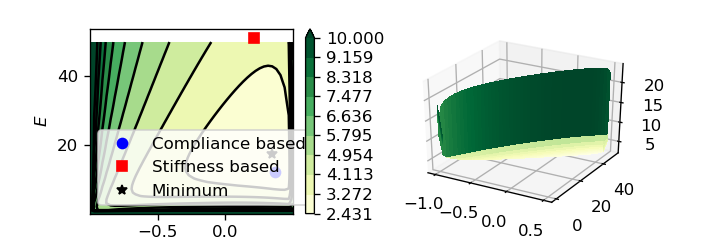

<IPython.core.display.Javascript object>


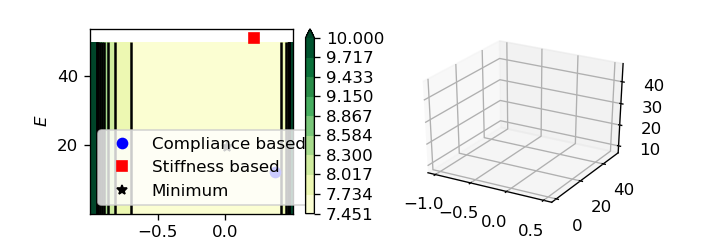

<IPython.core.display.Javascript object>


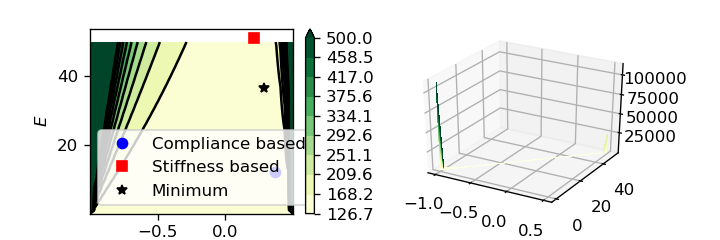

In [9]:
levels = np.linspace(np.min(dL), 10, 10)
fig = plt.figure(figsize=(6,2))
plot_setup(nu_vec, E_vec, props, dL, levels)
levels = np.linspace(np.min(dR), 10, 10)
fig = plt.figure(figsize=(6,2))
plot_setup(nu_vec, E_vec, props, dR, levels)
levels = np.linspace(np.min(dF), 500, 10)
fig = plt.figure(figsize=(6,2))
plot_setup(nu_vec, E_vec, props, dF, levels)

In [10]:
from IPython.core.display import HTML
def css_styling():
    styles = open('./styles/custom_barba.css', 'r').read()
    return HTML(styles)
css_styling()